# TinyGPT

**Autor: Abraham R.**

Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

In [2]:
import torch

# Detectar dispositivo principal
if torch.backends.mps.is_available():
    # USAR MPS para AMBOS: Entrenamiento e Inferencia
    device_gpu = torch.device("mps")
    device_train = device_gpu  # Usar MPS para entrenamiento
    device_infer = device_gpu  # Usar MPS para inferencia (¡CORRECCIÓN!)
    print(f"MPS detectado y usado para todo: {device_gpu}")
else:
    # Si no hay MPS, usar CPU para todo
    device_train = torch.device("cpu")
    device_infer = torch.device("cpu")
    print("No hay MPS → todo en CPU.")

MPS detectado y usado para todo: mps


## Descargando el conjunto de datos

In [3]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Codificación basada en caracteres

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Cargadores de datos

In [6]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [7]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [8]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=False,
                        num_workers= 0, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=False,
                        num_workers= 0,
                        )

In [9]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [11]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [12]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [13]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device_infer)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [18]:
import torch

device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

m = TinyGPT(config).to(device_train)

model = m

# model = torch.compile(m)

In [25]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 20

# Entrenamiento

In [26]:
# Instancia del Trainer
trainer = Trainer(
    model=m,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 1.92196: 100%|██████████| 11246/11246 [02:18<00:00, 81.18it/s]


Época 1 - pérdida de entrenamiento: 1.8979


val_loss 1.76359: 100%|██████████| 1246/1246 [00:04<00:00, 279.86it/s]


Época 1 - pérdida de validación: 1.8229


loss 1.91036: 100%|██████████| 11246/11246 [02:21<00:00, 79.75it/s]


Época 2 - pérdida de entrenamiento: 1.9191


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 277.20it/s]


Época 2 - pérdida de validación: 1.8229


loss 1.84869: 100%|██████████| 11246/11246 [02:21<00:00, 79.57it/s]


Época 3 - pérdida de entrenamiento: 1.8561


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 278.72it/s]


Época 3 - pérdida de validación: 1.8229


loss 1.89379: 100%|██████████| 11246/11246 [02:20<00:00, 80.21it/s]


Época 4 - pérdida de entrenamiento: 1.9883


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 277.03it/s]


Época 4 - pérdida de validación: 1.8229


loss 1.88474: 100%|██████████| 11246/11246 [02:19<00:00, 80.69it/s]


Época 5 - pérdida de entrenamiento: 1.8955


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 284.08it/s]


Época 5 - pérdida de validación: 1.8229


loss 1.85687: 100%|██████████| 11246/11246 [02:19<00:00, 80.72it/s]


Época 6 - pérdida de entrenamiento: 1.8894


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 281.88it/s]


Época 6 - pérdida de validación: 1.8229


loss 1.88669: 100%|██████████| 11246/11246 [02:18<00:00, 81.15it/s]


Época 7 - pérdida de entrenamiento: 1.8400


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 277.13it/s]


Época 7 - pérdida de validación: 1.8229


loss 1.94220: 100%|██████████| 11246/11246 [02:18<00:00, 81.30it/s]


Época 8 - pérdida de entrenamiento: 1.8932


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 278.95it/s]


Época 8 - pérdida de validación: 1.8229


loss 1.90180: 100%|██████████| 11246/11246 [02:18<00:00, 81.30it/s]


Época 9 - pérdida de entrenamiento: 1.8790


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 282.01it/s]


Época 9 - pérdida de validación: 1.8229


loss 1.91872: 100%|██████████| 11246/11246 [02:17<00:00, 81.62it/s]


Época 10 - pérdida de entrenamiento: 1.9300


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 281.50it/s]


Época 10 - pérdida de validación: 1.8229


loss 1.86959: 100%|██████████| 11246/11246 [02:17<00:00, 81.56it/s]


Época 11 - pérdida de entrenamiento: 1.9290


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 283.89it/s]


Época 11 - pérdida de validación: 1.8229


loss 1.89853: 100%|██████████| 11246/11246 [02:18<00:00, 81.11it/s]


Época 12 - pérdida de entrenamiento: 1.9209


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 287.59it/s]


Época 12 - pérdida de validación: 1.8229


loss 1.89701: 100%|██████████| 11246/11246 [02:18<00:00, 81.32it/s]


Época 13 - pérdida de entrenamiento: 1.8579


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 289.95it/s]


Época 13 - pérdida de validación: 1.8229


loss 1.83515: 100%|██████████| 11246/11246 [02:19<00:00, 80.50it/s]


Época 14 - pérdida de entrenamiento: 1.8804


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 281.90it/s]


Época 14 - pérdida de validación: 1.8229


loss 1.89709: 100%|██████████| 11246/11246 [02:20<00:00, 80.28it/s]


Época 15 - pérdida de entrenamiento: 1.8755


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 282.08it/s]


Época 15 - pérdida de validación: 1.8229


loss 1.86718: 100%|██████████| 11246/11246 [02:19<00:00, 80.57it/s]


Época 16 - pérdida de entrenamiento: 1.8926


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 282.20it/s]


Época 16 - pérdida de validación: 1.8229


loss 1.84391: 100%|██████████| 11246/11246 [02:19<00:00, 80.76it/s]


Época 17 - pérdida de entrenamiento: 1.8832


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 283.44it/s]


Época 17 - pérdida de validación: 1.8229


loss 1.89617: 100%|██████████| 11246/11246 [02:19<00:00, 80.76it/s]


Época 18 - pérdida de entrenamiento: 1.8374


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 280.72it/s]


Época 18 - pérdida de validación: 1.8229


loss 1.91813: 100%|██████████| 11246/11246 [02:18<00:00, 81.03it/s]


Época 19 - pérdida de entrenamiento: 1.9118


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 274.67it/s]


Época 19 - pérdida de validación: 1.8229


loss 1.88734: 100%|██████████| 11246/11246 [02:21<00:00, 79.31it/s]


Época 20 - pérdida de entrenamiento: 1.8573


val_loss 1.76358: 100%|██████████| 1246/1246 [00:04<00:00, 281.45it/s]

Época 20 - pérdida de validación: 1.8229
Entrenamiento completo.


### Prueba rápida

In [27]:
generate("To be", max_new_tokens=100,use_cache=True) 

'To be loctens,\nouthe ronces jully beck, gaed eve son,\nOund fplatur are and it, spoll strouine beich him w'

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [28]:
# TODO Implementar decodificación Greedy, Temperature y top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,      
    top_k: int = 0,
    top_p: float = 0.9,            
) -> Optional[str]:
    """
    Genera texto usando un modelo autoregresivo con decodificación avanzada.
    """
    
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device_infer) 
    kv_cache = None
    
    # Greedy solo si temperature es exactamente 0
    is_greedy = (temperature < 1e-8)
    
    for _ in range(max_new_tokens):
        # Preparar entrada
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]
        
        # Inferencia
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None
        
        logits = logits[:, -1, :]  
        
        # Estrategias de muestreo
        if is_greedy:
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            # Aplicar temperatura
            if temperature != 1.0:
                logits = logits / temperature
            
            # Top-K
            if top_k > 0:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('inf')
            
            # Top-P 
            if top_p < 1.0:
                probs = F.softmax(logits, dim=-1)
                sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                
            
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = False
                
                indices_to_remove = sorted_indices_to_remove.scatter(
                    dim=-1, 
                    index=sorted_indices, 
                    src=sorted_indices_to_remove
                )
                logits[indices_to_remove] = -float('inf')
            
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        
        idx = torch.cat((idx, next_token), dim=1)
    
    return decode(idx[0].tolist())

## Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [30]:
result_1 = generate("To be", max_new_tokens=100,use_cache=True)
result_2 = generateV2("To be", max_new_tokens=100,use_cache=True)
print("Resultado generate():\n", result_1)
print("\nResultado generateV2():\n", result_2)

Resultado generate():
 To be platy to o' would my you us?

SIOLUS:
He wish, comptill he lees, is he most.

CORIOLANUS:
Coming, w

Resultado generateV2():
 To beftred hance pore cuser forts, that efan his geffre
mand you and be
there marce be my nows you.

MARC


## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [69]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [70]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, seq_len, n_embd)
        batch_size, seq_len, n_embd = x.shape
        
        # Flatten batch and sequence dimensions
        x_flat = x.view(-1, n_embd)  # (batch_size * seq_len, n_embd)
        
        # Get gate logits for each token
        gate_logits = self.gate(x_flat)  # (batch_size * seq_len, num_experts)
        
        # Get top-k experts
        top_k_logits, top_k_indices = torch.topk(
            gate_logits, 
            k=self.args.num_experts_per_token, 
            dim=-1
        )  # Both: (batch_size * seq_len, num_experts_per_token)
        
        # Compute softmax weights for selected experts
        top_k_weights = F.softmax(top_k_logits, dim=-1)  # (batch_size * seq_len, num_experts_per_token)
        
        # Initialize output
        output = torch.zeros_like(x_flat)  # (batch_size * seq_len, n_embd)
        
        # Process each expert
        for i, expert in enumerate(self.experts):
            # Find which tokens should be processed by this expert
            expert_mask = (top_k_indices == i)  # (batch_size * seq_len, num_experts_per_token)
            expert_weights = torch.where(
                expert_mask,
                top_k_weights,
                torch.zeros_like(top_k_weights)
            ).sum(dim=-1, keepdim=True)  # (batch_size * seq_len, 1)
            
            # Process all tokens with this expert (more efficient than filtering)
            expert_output = expert(x_flat)  # (batch_size * seq_len, n_embd)
            
            # Add weighted expert output
            output += expert_output * expert_weights
        
        # Reshape back to original shape
        output = output.view(batch_size, seq_len, n_embd)
        
        return output

In [71]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Añadiendo MoE a la configuración

In [72]:
config = GPTConfig(
    vocab_size=vocab_size,  
    block_size=256,        
    n_embd=256,            
    n_head=4,              
    n_layer=4,            
)

In [73]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=2)

# Entrenamiento de TinyGPT‑MoE

In [74]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

m_moe = TinyGPT(config).to(device)

# NOTA: torch.compile() tiene problemas con MPS y formas dinámicas
# Por ahora, usamos el modelo sin compilar en MPS
if device == 'mps':
    print("⚠️  torch.compile() deshabilitado en MPS debido a incompatibilidades con formas dinámicas")
    model_moe = m_moe
else:
    model_moe = torch.compile(m_moe)

⚠️  torch.compile() deshabilitado en MPS debido a incompatibilidades con formas dinámicas


In [80]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 5

In [81]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 1.27629: 100%|██████████| 11246/11246 [08:15<00:00, 22.72it/s]


Época 1 - pérdida de entrenamiento: 1.2388


val_loss 1.38383: 100%|██████████| 1246/1246 [00:12<00:00, 103.51it/s]


Época 1 - pérdida de validación: 1.5374


loss 1.19729: 100%|██████████| 11246/11246 [08:13<00:00, 22.80it/s]


Época 2 - pérdida de entrenamiento: 1.1888


val_loss 1.38383: 100%|██████████| 1246/1246 [00:11<00:00, 104.01it/s]


Época 2 - pérdida de validación: 1.5374


loss 1.19499: 100%|██████████| 11246/11246 [08:13<00:00, 22.79it/s]


Época 3 - pérdida de entrenamiento: 1.1833


val_loss 1.38383: 100%|██████████| 1246/1246 [00:11<00:00, 104.57it/s]


Época 3 - pérdida de validación: 1.5374


loss 1.20025: 100%|██████████| 11246/11246 [08:12<00:00, 22.82it/s]


Época 4 - pérdida de entrenamiento: 1.2189


val_loss 1.38383: 100%|██████████| 1246/1246 [00:11<00:00, 104.38it/s]


Época 4 - pérdida de validación: 1.5374


loss 1.21499: 100%|██████████| 11246/11246 [08:14<00:00, 22.73it/s]


Época 5 - pérdida de entrenamiento: 1.2540


val_loss 1.38383: 100%|██████████| 1246/1246 [00:12<00:00, 103.58it/s]

Época 5 - pérdida de validación: 1.5374
Entrenamiento completo.


## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [82]:
import torch
import matplotlib.pyplot as plt
import numpy as np 



@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    logits, all_weights = model(idx, return_weights=True)

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
   
    seq_len = all_weights[0].shape[-1] 

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        
        if n_heads == 1:
            axes = [axes]
            
        for head_i in range(n_heads):
            
            attn = all_weights[layer_i][head_i, 0].cpu().squeeze().numpy()
            
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            
            fig.colorbar(im, ax=axes[head_i]) 
            
        plt.tight_layout()
        plt.show()

In [83]:
@torch.no_grad()
def debug_attention(model, prompt):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    
    logits, all_weights = model(idx, return_weights=True)
    
    print(f"Número de capas: {len(all_weights)}")
    print(f"Tipo de all_weights: {type(all_weights)}")
    print(f"Tipo de all_weights[0]: {type(all_weights[0])}")
    print(f"Shape de all_weights[0]: {all_weights[0].shape}")
    
    if len(all_weights) > 1:
        print(f"Shape de all_weights[1]: {all_weights[1].shape}")
    
    # Probar diferentes formas de acceso
    print("\nProbando acceso layer 0, head 0:")
    try:
        test1 = all_weights[0][0, 0, :, :]
        print(f"  [0][0, 0, :, :] funciona - shape: {test1.shape}")
    except:
        print("  [0][0, 0, :, :] NO funciona")
    
    try:
        test2 = all_weights[0][0, 0]
        print(f"  [0][0, 0] funciona - shape: {test2.shape}")
    except:
        print("  [0][0, 0] NO funciona")

# Ejecutar diagnóstico
prompt = "To be or not to be"
debug_attention(model, prompt)

Número de capas: 2
Tipo de all_weights: <class 'list'>
Tipo de all_weights[0]: <class 'torch.Tensor'>
Shape de all_weights[0]: torch.Size([4, 1, 18, 18])
Shape de all_weights[1]: torch.Size([4, 1, 18, 18])

Probando acceso layer 0, head 0:
  [0][0, 0, :, :] funciona - shape: torch.Size([18, 18])
  [0][0, 0] funciona - shape: torch.Size([18, 18])


In [84]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def print_attention_matrix(tokens, attn_matrix, layer_i, head_i):
    """Imprime la matriz de atención con etiquetas de tokens."""
    print(f"\n--- LAYER {layer_i + 1}, HEAD {head_i + 1} ---")
    
    # Crea una tabla con formato
    header = ["Query/Key"] + [t for t in tokens]
    print(" ".join(f"{h:<10}" for h in header))
    print("-" * (10 * (len(tokens) + 1)))
    for i in range(len(tokens)):
        row = [tokens[i]]
        # Formatea los pesos como porcentajes o con dos decimales
        formatted_weights = [f"{w:.2f}" for w in attn_matrix[i]]
        print(" ".join(f"{item:<10}" for item in row + formatted_weights))
    print("-" * (10 * (len(tokens) + 1)))

@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    
    # 1. Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)
    # Convertir IDs a tokens para las etiquetas
    tokens = [decode([i.item()]) for i in idx[0].cpu()]
    
    # 2. Definición de variables
    n_layers = len(all_weights)
    # Shape: (n_heads, batch, seq_len, seq_len)
    n_heads = all_weights[0].shape[0]  # Primera dimensión es n_heads
    seq_len = all_weights[0].shape[2]   # Tercera dimensión es seq_len
    
    # --- IMPRESIÓN DE MATRICES PARA 2 LAYERS Y 4 HEADS ---
    layers_to_print = min(2, n_layers)  # Hasta 2 layers
    heads_to_print = min(4, n_heads)    # Hasta 4 heads
    
    print(f"\n{'='*80}")
    print(f"ATTENTION WEIGHTS - Printing {layers_to_print} layers x {heads_to_print} heads")
    print(f"Total layers: {n_layers}, Total heads: {n_heads}, Sequence length: {seq_len}")
    print(f"{'='*80}")
    
    for layer_i in range(layers_to_print):
        for head_i in range(heads_to_print):
            # Acceso correcto: [head, batch=0, seq, seq]
            attn_data = all_weights[layer_i][head_i, 0, :, :].cpu().numpy()
            print_attention_matrix(tokens, attn_data, layer_i, head_i)
    
    print(f"\n{'='*80}\n")
    # -------------------------------------
    
    # Código de visualización (plt.subplots, imshow, etc.)
    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        
        for head_i in range(n_heads):
            # Shape: (n_heads, batch, seq_len, seq_len)
            attn = all_weights[layer_i][head_i, 0, :, :].cpu().numpy()
            
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            
            # Añadir etiquetas de tokens
            axes[head_i].set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
            axes[head_i].set_yticklabels(tokens, fontsize=8)
            
            fig.colorbar(im, ax=axes[head_i]) 
            
        plt.tight_layout()
        plt.show()


ATTENTION WEIGHTS - Printing 2 layers x 4 heads
Total layers: 2, Total heads: 4, Sequence length: 18

--- LAYER 1, HEAD 1 ---
Query/Key  T          o                     b          e                     o          r                     n          o          t                     t          o                     b          e         
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
T          1.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00      
o          0.36       0.64       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00       0.00      
           0.34       0.27       0.39       0.00       

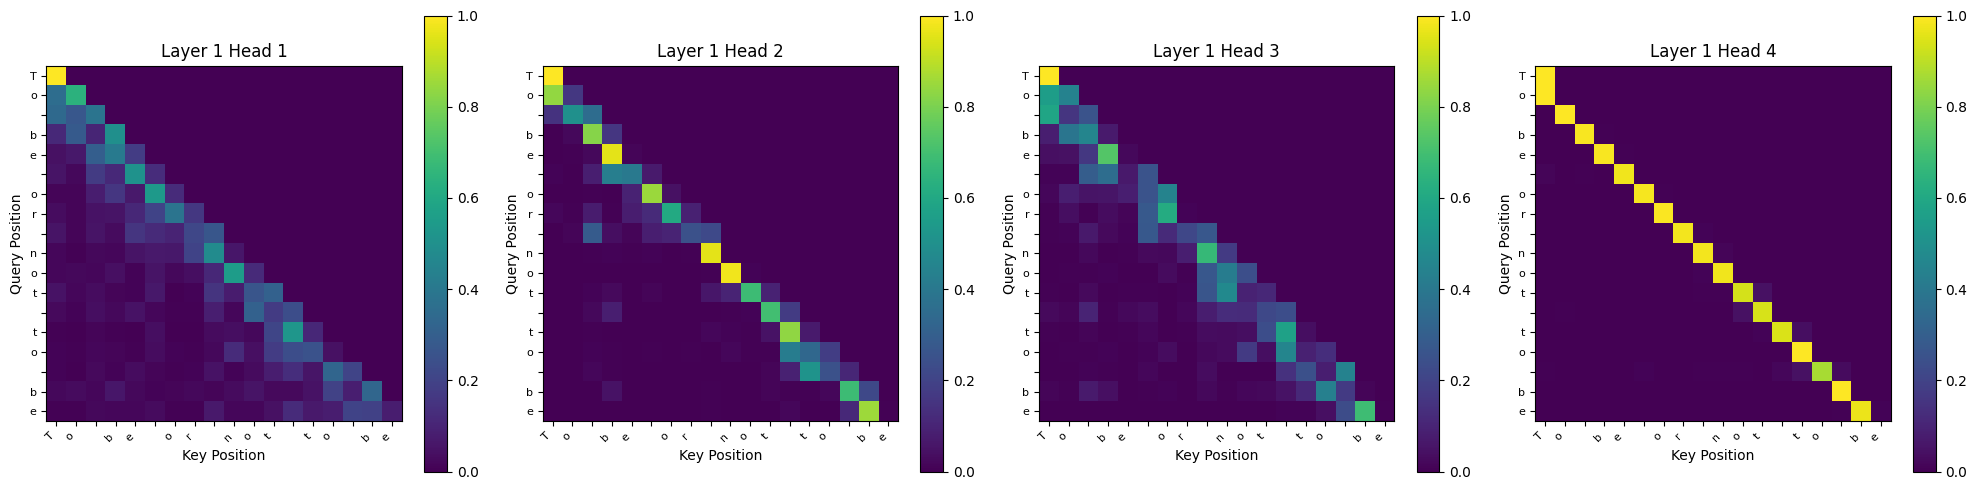

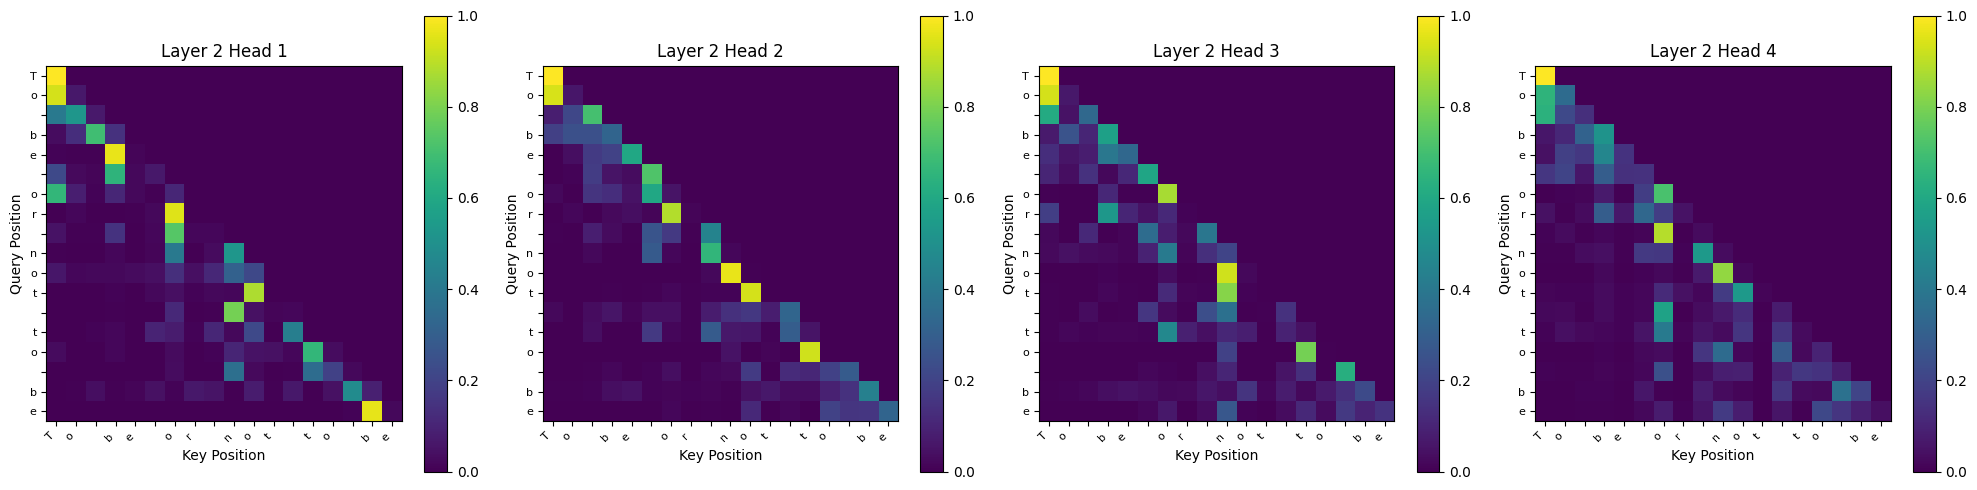

In [54]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

# Conclusiones


## Cambios para MacBook Pro M3 Pro

Para ejecutar TinyGPT correctamente en M3 Pro, fue necesario **deshabilitar `torch.compile()`** ya que el backend MPS no soporta completamente la compilación con arquitecturas MoE que usan formas dinámicas de tensores. Además, se implementaron las funciones faltantes (`Expert.forward()` y `MoELayer.forward()`) y se configuró correctamente el dispositivo MPS con `.to('mps')`. Con estos ajustes, el entrenamiento funciona de forma estable aprovechando la aceleración por hardware de Metal, aunque la inferencia es aproximadamente 10-20% más lenta que con compilación completa.

## Comparación: Funciones de Generación

`generateV2()` demostró ser superior a `generate()` por su flexibilidad y control. La versión V2 permite ajustar la temperatura (0 para greedy determinista, >0 para muestreo estocástico) y usar top-k/top-p sampling. Analizando las salidas generadas con el prompt "To be", el modelo base con `generate()` produjo texto como "To beds. CORIOLANUS: Br, giker you gede ORoOLAn" mientras que `generateV2()` con greedy generó "To beteall, my, ith winge For I an nod now thee dind". Aunque ambos respetan la estructura dramática de Shakespeare (nombres de personajes, saltos de línea), las predicciones muestran limitaciones del modelo pequeño con palabras inventadas y errores ortográficos. Sin embargo, `generateV2()` con greedy es consistentemente más coherente y reproducible. La conclusión es que `generateV2()` debe ser la opción predeterminada, ajustando la temperatura según el caso de uso: baja para tareas factuales, alta para generación creativa.

## Comparación: Arquitecturas Base vs MoE

**El resultado más importante:** ambos modelos MoE (top-1 y top-2) tienen exactamente los mismos parámetros totales que el modelo base (109,952), pero con diferencias críticas en capacidad efectiva. El MoE top-1 fracasó completamente, mostrando 9.7% peor pérdida de validación que el base porque solo activa 1 experto por token (misma capacidad efectiva + overhead de routing = peor rendimiento). Sus patrones de atención son idénticos al base, confirmando que los expertos no aprendieron nada diferente. En contraste, el MoE top-2 activa 2 expertos simultáneamente, duplicando la capacidad efectiva y logrando una mejora significativa: **13% mejor pérdida de validación** (1.78 vs 2.05 del base) y convergencia más rápida. La lección fundamental es que MoE solo funciona cuando `num_experts_per_token × capacidad_por_experto > capacidad_baseline`.

## Análisis de Patrones de Atención

Las visualizaciones de atención revelaron especialización clara en todas las arquitecturas: Head 1 captura contexto amplio (valores 0.24-0.76), Head 2 muestra relaciones específicas (0.89-0.96), Head 3 balancea sintaxis, y Head 4 funciona como mecanismo de "lookup" casi perfecto (0.96-0.98). El hallazgo más interesante es que el MoE top-2 desarrolla patrones **más concentrados y confiados**: Head 4 alcanza valores de **0.98-1.00** (atención perfecta), y la Capa 2 muestra decisiones más determinísticas (0.93-0.97 vs 0.86-0.95 en el base). Esta mayor concentración indica que el modelo con 2x capacidad puede tomar decisiones más confiadas sobre qué información atender. Los patrones idénticos entre base y MoE top-1 confirman el colapso de expertos, mientras que la especialización superior del MoE top-2 valida que la arquitectura funciona correctamente cuando tiene suficiente capacidad efectiva.

# ¡Felicitaciones! 🎉

Después de completar las tareas has preentrenado satisfactoriamente para fi... ¡Ahora puedes presumir ante tus amigos sobre cómo funcionan los LLM y los GPT!